In [9]:
import spotipy
import spotipy.util as util

client_id = 'a4601a5ae121413e9450015d6c0febaa'
client_secret = 'ed18559d5243412281ab9c5e80a0db65'
username='5dpgk6tgb1w0swe0ni3v8s1c9'
redirect_uri='http://localhost:3000/'


token = util.prompt_for_user_token(
        username=username,
        scope=['user-read-recently-played'],
        client_id=client_id,
        client_secret=client_secret,
        redirect_uri=redirect_uri)

sp = spotipy.Spotify(auth=token)

In [2]:
def get_daily_songs(start, stop):
    names, uris, artists, recent_list = [], [], [], []
    
    # get the songs from Sep 1st 0am to Sep 2nd 0am

    # stop when after is past sep 1st 0am
    while (start > stop):

        recent_play = sp.current_user_recently_played(before=start, limit=50) # start at sep 2nd 0am
        after = int(recent_play['cursors']['after'])

        # if goes over, find the limit threshold
        if after < stop:
            limit = get_right_limit(stop, start)
            if limit != 0:
                recent_play = sp.current_user_recently_played(before=start, limit=limit)
            else:
                break

        recent_list.extend( recent_play['items'] ) 
        start = after

    for i in range(len(recent_list)):
        this_song = recent_list[i]['track']
        names.append(this_song['name'])
        uris.append(this_song['uri'])
        artists.append(this_song['artists'][0]['name'])
        
    return names, uris, artists

def get_right_limit(left, right):
    limit=50
    while limit > 0:
        obj = sp.current_user_recently_played(before=right, limit=limit)
        after = int(obj ['cursors']['after'])
        if after > left:
            break
        limit -= 1
    
    return limit

In [3]:
def get_features_for_playlist(df, start, stop):
  
    # get all track metadata from given playlist
    song_names, song_uris, song_artists = get_daily_songs(start, stop)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(song_names, song_artists, song_uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset]
        df.loc[len(df.index)] = row
    return df

In [10]:
import pandas as pd
import time
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 
'speechiness', 'tempo', 'valence'])
curr_time = int(round(time.time() * 1000))
df = get_features_for_playlist(df, curr_time, curr_time - 86400000)
df.head(5)

In [8]:
for i in df['name']:
    print(i)

Trái Tim Em Cũng Biết Đau
Có Những Yêu Thương Nào
Cảm Nắng
Một Cú Lừa
the 1
Don't Call Me
So It Goes...
Cruel Summer
첫 사랑니 (Rum Pum Pum Pum)
La Vie en Rose
SOLO
Oh my god
The Boys
New Face
Renegade (feat. Taylor Swift)
Make A Wish (Birthday Song)
넘버나인
LATATA
Dingga
In the morning
Adios
Haru Haru
KILLING ME
BLACK
Mr.Mr.
Peek-A-Boo
LO$ER=LO♡ER
Anti-Romantic
Da Lo Yeu Em Nhieu
I Like That
Mamma Mia
LET'S NOT FALL IN LOVE
우리 사랑했잖아
공허해 empty
Eternally
Cat & Dog
9 and Three Quarters - Run Away
Can't You See Me?
CROWN
Anti-Romantic
Lovey-Dovey
Lip & Hip
See U Later
WHISTLE
Heart Attack
The Eve
무제(無題) (Untitled, 2014)
Lonely
Blue
hoax
Có Những Yêu Thương Nào
Cảm Nắng
Một Cú Lừa
the 1
Don't Call Me
So It Goes...
Cruel Summer
첫 사랑니 (Rum Pum Pum Pum)
La Vie en Rose
SOLO
Oh my god
The Boys
New Face
Renegade (feat. Taylor Swift)
Make A Wish (Birthday Song)
넘버나인
LATATA
Dingga
In the morning
Adios
Haru Haru
KILLING ME
BLACK
Mr.Mr.
Peek-A-Boo
LO$ER=LO♡ER
Anti-Romantic
Da Lo Yeu Em Nhieu
I Like That
Ma

In [5]:
non_features = ['name', 'artist', 'track_URI']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.888,0.602,0.494,0.000026,0.0902,-10.813,0.0277,94.955,0.374
1,0.130,0.627,0.792,0.000004,0.0845,-4.311,0.0310,119.054,0.415
2,0.801,0.592,0.410,0.000014,0.0900,-12.426,0.0397,151.923,0.416
3,0.964,0.676,0.178,0.000008,0.1350,-15.010,0.0394,118.840,0.404
4,0.103,0.760,0.703,0.000000,0.0913,-5.412,0.0540,95.997,0.570


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

pca = PCA()
pca.fit(X_std);
evr = pca.explained_variance_ratio_

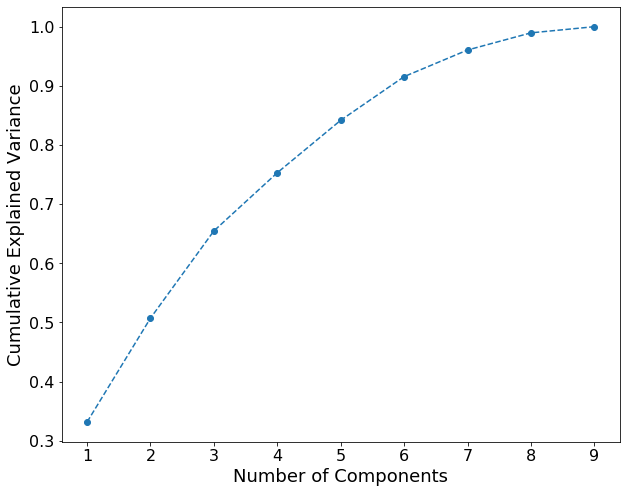

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()
# need 6 components

In [8]:
pca = PCA(n_components=5)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

In [9]:
from sklearn.cluster import KMeans
import seaborn as sns
from kneed import KneeLocator

wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)

Optimal number of clusters 5


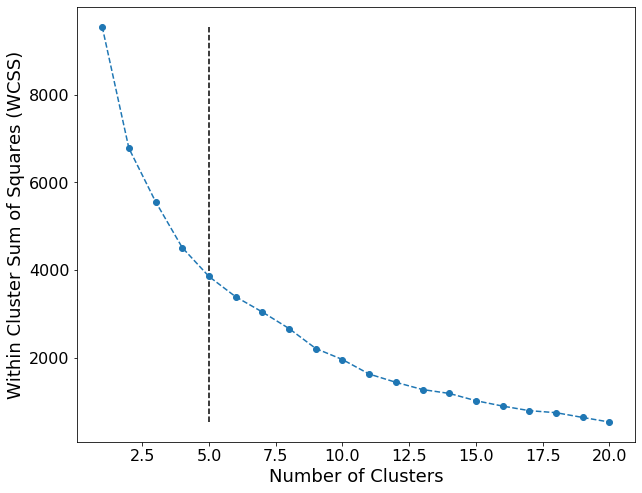

In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# fig.savefig("./visualizations/num_clusters.png")
plt.show()

In [11]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

In [12]:
n_comps=5
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster
0,0.888,0.602,0.494,0.000026,0.0902,-10.813,0.0277,94.955,0.374,-1.214783,-0.490812,-0.990291,0.132900,-0.429052,4
1,0.130,0.627,0.792,0.000004,0.0845,-4.311,0.0310,119.054,0.415,2.321878,-0.244031,-1.021023,-0.377261,0.606415,3
2,0.801,0.592,0.410,0.000014,0.0900,-12.426,0.0397,151.923,0.416,-1.302827,1.165441,-0.739690,0.612014,-0.841449,1
3,0.964,0.676,0.178,0.000008,0.1350,-15.010,0.0394,118.840,0.404,-2.628423,0.028065,-0.662182,0.910082,-1.438803,4
4,0.103,0.760,0.703,0.000000,0.0913,-5.412,0.0540,95.997,0.570,2.756519,-0.854010,-0.818544,0.705827,-0.598703,3


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


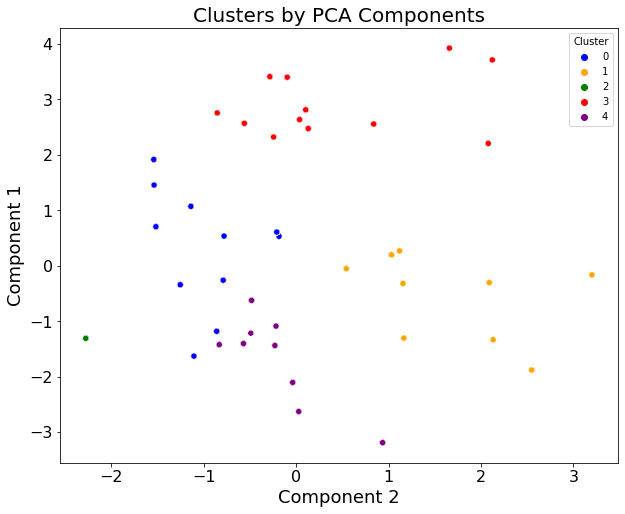

In [15]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette=['blue', 'orange','green', 'red', 'purple'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [16]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df

,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,seven,Taylor Swift,spotify:track:76mOLcXOjOEhyY4mMF1l3r,0.888,0.602,0.494,0.000026,0.0902,-10.813,0.0277,94.955,0.374,4
1,Love Story (Taylor’s Version),Taylor Swift,spotify:track:6YvqWjhGD8mB5QXcbcUKtx,0.130,0.627,0.792,0.000004,0.0845,-4.311,0.0310,119.054,0.415,3
2,it’s time to go - bonus track,Taylor Swift,spotify:track:1kdWw77ZpYOkhxeuhzU1j6,0.801,0.592,0.410,0.000014,0.0900,-12.426,0.0397,151.923,0.416,1
3,hoax,Taylor Swift,spotify:track:0YeDG5HnKnG7jpArkzsSPa,0.964,0.676,0.178,0.000008,0.1350,-15.010,0.0394,118.840,0.404,4
4,Blank Space,Taylor Swift,spotify:track:2sC2P3BN0IXujNaaSyDmtP,0.103,0.760,0.703,0.000000,0.0913,-5.412,0.0540,95.997,0.570,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,Màu Nước Mắt,Nguyễn Trần Trung Quân,spotify:track:3bU3vSXYFgoN6eW2PG0wTk,0.622,0.427,0.378,0.000000,0.1180,-8.116,0.0287,81.449,0.324,4
1256,Trời Giấu Trời Mang Đi,AMEE,spotify:track:5bci9SuYMCNB2BkSEmrCaB,0.676,0.423,0.411,0.000000,0.1860,-8.892,0.0971,183.982,0.372,1
1257,"ex's hate me, Pt. 2",AMEE,spotify:track:0Rx4GFPy8ISxPhRwkjl64b,0.743,0.653,0.403,0.000000,0.1410,-8.279,0.0577,80.056,0.398,0
1258,Rồi Người Thương Cũng Hóa Người Dưng,Hiền Hồ,spotify:track:6foM17AKOK0NMOXIpuZtAm,0.953,0.571,0.321,0.000037,0.1170,-8.093,0.0277,80.039,0.340,4


In [17]:
def make_normalized_df(df, col_sep):
    non_features = df[df.columns[:col_sep]]
    features = df[df.columns[col_sep:]]
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = df.columns[col_sep:])
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = df['Cluster']
orig = df.drop(columns=['Cluster'])
values_df = make_normalized_df(orig, 3)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,seven,Taylor Swift,spotify:track:76mOLcXOjOEhyY4mMF1l3r,4,0.916123,0.470377,0.447781,0.000308,0.103406,0.354956,0.015742,0.182916,0.448091
1,Love Story (Taylor’s Version),Taylor Swift,spotify:track:6YvqWjhGD8mB5QXcbcUKtx,3,0.131200,0.515260,0.836815,0.000047,0.086071,0.904855,0.040480,0.404095,0.509248
2,it’s time to go - bonus track,Taylor Swift,spotify:track:1kdWw77ZpYOkhxeuhzU1j6,1,0.826033,0.452424,0.338120,0.000165,0.102798,0.218539,0.105697,0.705765,0.510740
3,hoax,Taylor Swift,spotify:track:0YeDG5HnKnG7jpArkzsSPa,4,0.994822,0.603232,0.035248,0.000094,0.239659,0.000000,0.103448,0.402131,0.492840
4,Blank Space,Taylor Swift,spotify:track:2sC2P3BN0IXujNaaSyDmtP,3,0.103241,0.754039,0.720627,0.000000,0.106752,0.811739,0.212894,0.192480,0.740453


In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()

In [19]:
# import lyricsgenius as lg
# api_key = "CDB6HYHpNh2-NpAcZFcLgk58jJcgHTxySeWyef1xDc7yAfoWVYnG466szRMUMMsn"
# genius = lg.Genius(api_key, skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"], remove_section_headers=True)

In [25]:
# def get_lyrics(artists, songs):
#     lyric_list = []
#     for song, artist_name in zip(songs, artists):
#         try:
#             this_song = genius.search_song(song, artist_name)
#             print(f"Songs grabbed:{this_song}")
#             lyric_list.append(this_song.lyrics)
#         except:
#             print(f"some exception at {artist_name}: {song}")
#             lyric_list.append(np.nan)
#     return lyric_list

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, n_jobs=-1)
train = values_df.loc[:,'acousticness':]
lr.fit(train, values_df.cluster)

LogisticRegression(n_jobs=-1, random_state=0)

In [64]:
df_score = values_df.copy()
df_score.insert(4, 'score_class_1', lr.predict_proba(train)[:,1])
df_score.sort_values('score_class_1', inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



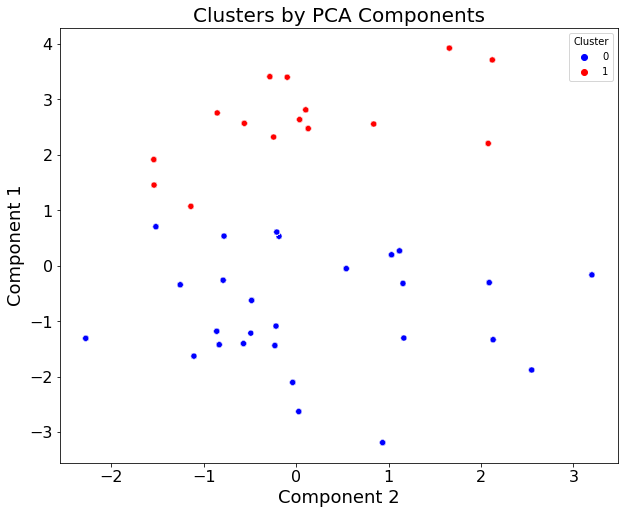

In [70]:
k_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)
k_pca.fit(scores_pca);

n_comps=5
km = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
km.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
km['Cluster'] = k_pca.labels_

x = km['Component 2']
y = km['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=km['Cluster'], palette=['blue', 'red'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# for i in range(len(df_score)):
#     name = df_score.loc[i, 'name']
#     score = df_score.loc[i, 'score_class_1']
#     print(f'Song: {name}, score: {score}')

In [82]:
df_score = values_df.copy()
df_score['cluster'] = km['Cluster']

lr = LogisticRegression(random_state=0, n_jobs=-1)
train = df_score.loc[:,'acousticness':]
lr.fit(train, df_score.cluster)
df_score.insert(4, 'score_class_1', lr.predict_proba(train)[:,1])
df_score.drop_duplicates(inplace=True)
df_score.sort_values('score_class_1', inplace=True)
df_score.reset_index(drop=True, inplace=True)
df_score
for i in range(len(df_score)):
    name = df_score.loc[i, 'name']
    score = df_score.loc[i, 'score_class_1']
    print(f'Song: {name}, score: {score}')

Song: Trong Tri Nho Cua Anh Cover - Original, score: 4.915621303495179e-05
Song: hoax, score: 0.00015034232758942613
Song: Có Chàng Trai Viết Lên Cây, score: 0.00021571844462199002
Song: Lạ Lùng, score: 0.0004023033347083977
Song: Ngày Chưa Giông Bão, score: 0.0010595793571265665
Song: Điều Buồn Nhất, score: 0.0010911671991412067
Song: Nhắm Mắt Thấy Mùa Hè, score: 0.0021417442806758273
Song: it’s time to go - bonus track, score: 0.0021892992040456064
Song: Rồi Người Thương Cũng Hóa Người Dưng, score: 0.0025730984269539477
Song: Chuyện Ngày Sau Kể, score: 0.003070152192380981
Song: Mot Dem Say (X), score: 0.004537900465988904
Song: seven, score: 0.004602455729896201
Song: Thanh Xuan, score: 0.0046743723490265
Song: Trời Giấu Trời Mang Đi, score: 0.005088225127625398
Song: Em Gái Mưa, score: 0.006474262378668355
Song: Chiều Nay Không Có Mưa Bay, score: 0.009450679603511541
Song: Màu Nước Mắt, score: 0.01332065735987624
Song: Đừng Nói Tôi Điên, score: 0.02202564135141288
Song: Yêu Một Ngư

In [84]:
import pickle
pickle.dump(lr, open("deploy_model.sav", 'wb'))

In [110]:
from datetime import datetime
zeros = np.zeros((1, 2))
result_df = pd.DataFrame(zeros, columns = ['timestamp','results'])
result_df.loc[0, 'results'] = np.mean(df_score['score_class_1'])
result_df.loc[0, 'timestamp'] = '2021-09-06'
# formats = "%Y-%m-%d"
result_df['timestamp'] = pd.to_datetime(result_df['timestamp'], format='%Y-%m-%d')
result_df

,timestamp,results
0,2021-09-06,0.356201


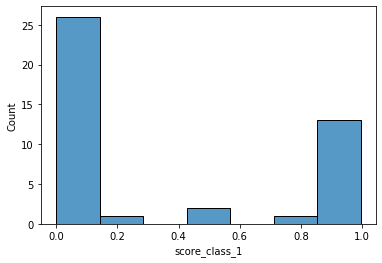

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.histplot(df_score['score_class_1'])

In [123]:
from sqlalchemy import create_engine
# engine = create_engine('sqlite://', echo=False)
conn = sqlite3.connect('schema.sql')
# result_df.to_sql('users', con=engine)
# engine.execute("SELECT * FROM users").fetchall()
result_df.to_sql('result', conn, if_exists='replace')

In [111]:
!pip install ipython-sql

     |████████████████████████████████| 42 kB 1.3 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13699 sha256=971964897982e76bb902c69adad7f6e3be2e9711ab30b332fbd97f3fe3abda82
  Stored in directory: /Users/irenechang/Library/Caches/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6
Successfully built prettytable
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [124]:
import sqlalchemy
sqlalchemy.create_engine('sqlite:///schema.db')

Engine(sqlite:///schema.db)

In [125]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [126]:
%sql sqlite:///schema.sql

In [127]:
%%sql

SELECT * FROM result

   sqlite:///schema.db
 * sqlite:///schema.sql
Done.


index,timestamp,results
0,2021-09-06 00:00:00,0.35620118221405744
